In [1]:
import os
import random
from IPython.display import HTML
import cv2
import tensorflow as tf
import numpy as np
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential
from keras.layers import *
import matplotlib.pyplot as plt
from keras.utils import plot_model
sns.set_style("darkgrid")
# ax= plt.subplot()
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping

In [2]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
CLASSES_LIST = ["NonViolence", "Violence"]
video_dir="Our Dataset/"

def frame_extraction(video_path):
    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    skip_frames_window = max(int(video_frame_count / SEQUENCE_LENGTH), 1)
    frame_list = []
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, skip_frames_window * frame_counter)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frame_list.append(normalized_frame)

    video_reader.release()
    return frame_list

def create_dataset():
    features = []
    labels = []
    video_file_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print("Extracing data of class:", class_name)
        files_list = os.listdir(os.path.join(video_dir, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(video_dir, class_name, file_name)
            frames = frame_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels, video_file_paths

if __name__=="__main__":
    print("Feature extracting...")
    features,labels,video_file_paths=create_dataset()
    np.save("Features/features_Own.npy", features)
    np.save("Features/labels_Own.npy", labels)
    np.save("Features/video_file_paths_Own.npy", video_file_paths)
    print("Saved feature files successfully")


Feature extracting...
Extracing data of class: NonViolence


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-3285b14a9f7d>", line 45, in <cell line: 0>
    features,labels,video_file_paths=create_dataset()
                                     ^^^^^^^^^^^^^^^^
  File "<ipython-input-2-3285b14a9f7d>", line 30, in create_dataset
    files_list = os.listdir(os.path.join(video_dir, class_name))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'Our Dataset/NonViolence'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'FileNotFoundError' object has no attribute '

TypeError: object of type 'NoneType' has no len()

In [2]:
from google.colab import drive
drive.mount('/content/drive')  # Mount the entire Google Drive


Mounted at /content/drive


In [3]:
file_path = "/content/drive/My Drive/features_Own.npy"
!cp "/content/drive/My Drive/features_Own.npy" /content/


In [4]:
features,labels=np.load("/content/features_Own.npy"),np.load("/content/labels_Own.npy")

In [5]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2,
                                                                            shuffle=True, random_state=42)

In [6]:
print(features_train.shape,labels_train.shape)
print(features_test.shape,labels_test.shape)

(1600, 16, 64, 64, 3) (1600, 2)
(400, 16, 64, 64, 3) (400, 2)


In [7]:
# from keras.applications.mobilenet_v2 import MobileNetV2

# mobilenet = MobileNetV2( include_top=False , weights="imagenet")

# #Fine-Tuning to make the last 40 layer trainable
# mobilenet.trainable=True

# for layer in mobilenet.layers[:-40]:
#   layer.trainable=False


In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, Flatten, Bidirectional
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import plot_model

# Define the input shape constants
SEQUENCE_LENGTH = 16
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
CLASSES_LIST =  ["NonViolence", "Violence"]

def create_model():
    # Load the MobileNetV2 model without the top layer
    base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    base_model.trainable = True  # Fine-tune last 40 layers

    for layer in base_model.layers[:-40]:  # Freeze initial layers
        layer.trainable = False

    # Define the model
    model = Sequential()

    # Input shape for time-distributed images
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Apply MobileNetV2 inside TimeDistributed
    model.add(TimeDistributed(base_model))
    model.add(TimeDistributed(Flatten()))

    # LSTM layers
    model.add(Bidirectional(LSTM(32, return_sequences=False)))

    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

<ipython-input-8-24f762706c35>:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 2, 2, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 5120)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │       1,319,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,637,090 (13.87 MB)

 Trainable params: 3,060,642 (11.68 MB)

 Non-trainable params: 576,448 (2.20 MB)

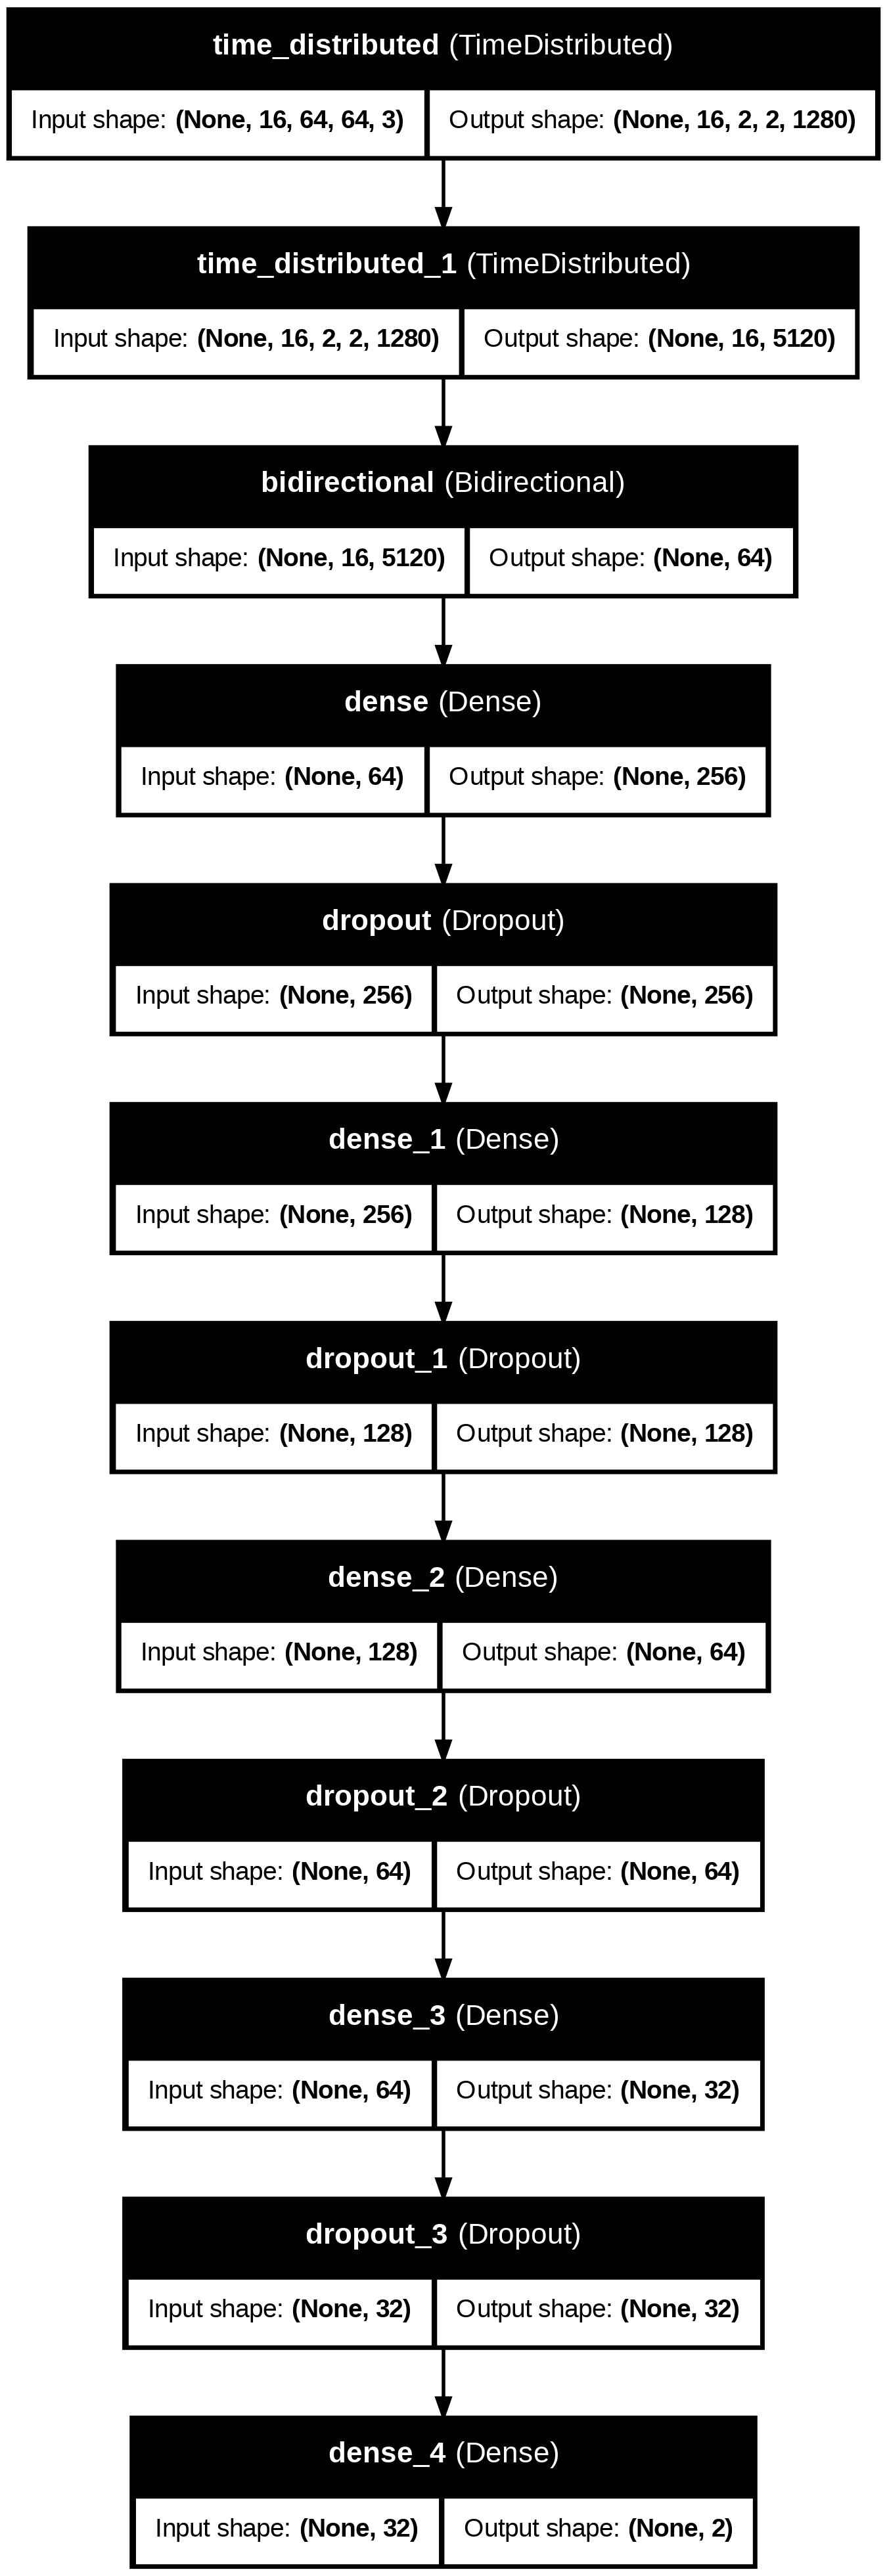

In [9]:
Own_dataset_mobi_Lstm=create_model()
plot_model(Own_dataset_mobi_Lstm, to_file="lstm_model.png",show_shapes=True,show_layer_names=True)

In [10]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

# Compiling the model
Own_dataset_mobi_Lstm.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

# Fitting the model
MobBiLSTM_model_history = Own_dataset_mobi_Lstm.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 168s 355ms/step - accuracy: 0.4962 - loss: 0.6974 - val_accuracy: 0.6656 - val_loss: 0.6820 - learning_rate: 0.0100
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - accuracy: 0.5612 - loss: 0.6843 - val_accuracy: 0.6125 - val_loss: 0.6770 - learning_rate: 0.0100
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 174ms/step - accuracy: 0.5702 - loss: 0.6718 - val_accuracy: 0.7063 - val_loss: 0.6129 - learning_rate: 0.0100
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.7064 - loss: 0.5842 - val_accuracy: 0.8094 - val_loss: 0.4627 - learning_rate: 0.0100
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.8078 - loss: 0.4469 - val_accuracy: 0.8031 - val_loss: 0.4967 - learning_rate: 0.0100
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.8569 - loss: 0.3681 - val_accuracy: 0.7688 - val_loss: 0.5648 - learning_rate: 0.0100
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.

In [11]:
model_evaluation_history = Own_dataset_mobi_Lstm.evaluate(features_test, labels_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.9252 - loss: 0.1810


In [12]:
labels_predict = Own_dataset_mobi_Lstm.predict(features_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step


In [13]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [14]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9275


In [15]:
Own_dataset_mobi_Lstm.save('Trained_models/Own_dataset_mobi_Lstm.h5')

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


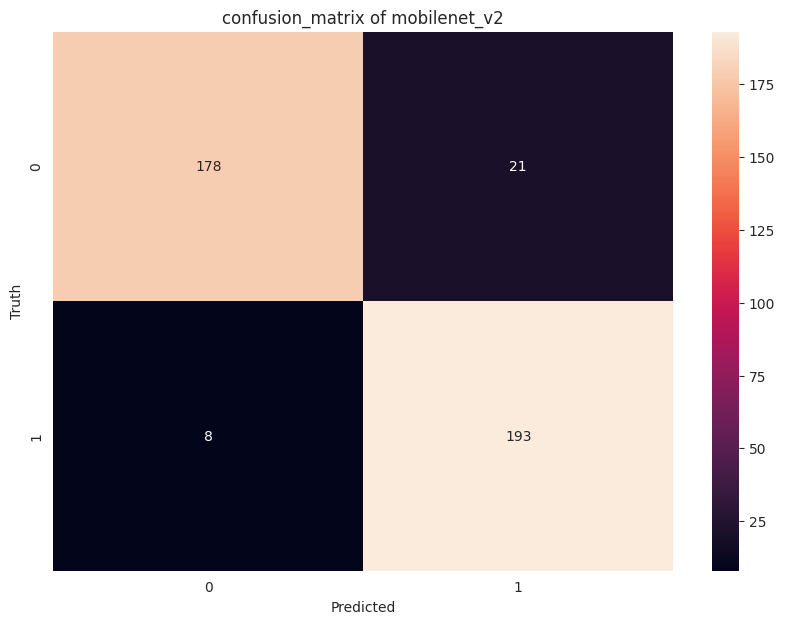


Classification Report of mobilenet_v2:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       199
           1       0.90      0.96      0.93       201

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



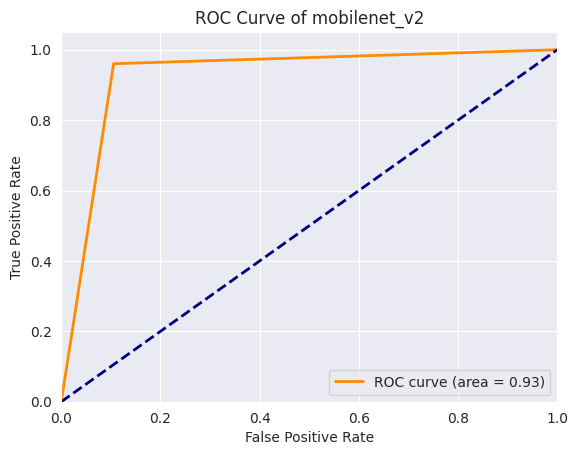

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import seaborn as sns

# Assuming `predicted_labels` are the predictions of your model on the test set
predicted_labels = Own_dataset_mobi_Lstm.predict(features_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(labels_test, axis=1)
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("confusion_matrix of mobilenet_v2")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Classification Report
print("\nClassification Report of mobilenet_v2:")
print(classification_report(true_labels, predicted_labels))

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of mobilenet_v2')
plt.legend(loc="lower right")
plt.show()


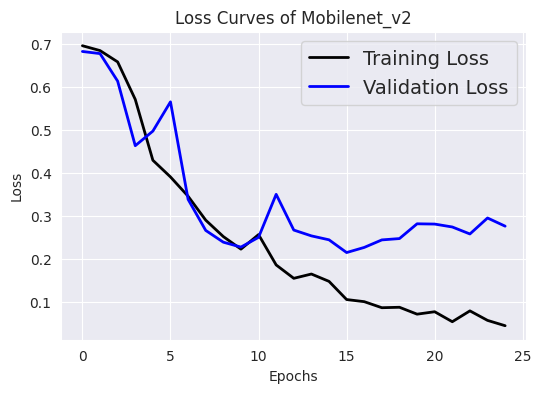

In [17]:
# `MobBiLSTM_model_history` is the returned object from your model's fit method
history = MobBiLSTM_model_history

# Plotting the loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves of Mobilenet_v2', fontsize=12)
plt.show()